In [1]:
import pandas as pd

import fsspec

fs = fsspec.filesystem(
    'filecache',
    target_protocol='s3',
    target_options={
        'key': 'YCAJEZ9PJ6itAHdK91ZPoWAp1',
        'secret': 'YCMesgjgH3dgexMVchUF5d9XRzBqYJGFllsUTP3v',
        'client_kwargs': {'endpoint_url': 'https://storage.yandexcloud.net'}
    },
    cache_storage='data',
    check_files=True)

In [2]:
with fs.open('s3://snap-simfin/us-shareprices-daily.zip') as f:
    prices = pd.read_csv(f, compression='zip', sep=';')

prices['Date'] = pd.to_datetime(prices.Date)

sp500tr = pd.read_csv('sp500tr.csv', sep=';', header=None, names=['date', 'value'])
sp500tr['date'] = pd.to_datetime(sp500tr.date, dayfirst=True)
sp500tr = sp500tr.set_index('date').sort_index()
sp500tr['scaling'] = sp500tr.value.pct_change() + 1
sp500tr['scaling_c'] = sp500tr.scaling.cumprod()

prices['index_scaling_c'] = prices.Date.map(sp500tr.scaling_c)
prices = prices.set_index(['Ticker', 'Date']).sort_index()

prices['price_scaling'] = prices.groupby('Ticker').Close.pct_change() + 1
prices['div_scaling'] = (prices.Dividend / prices.Close).fillna(0) + 1
prices['scaling'] = prices.price_scaling * prices.div_scaling
prices['scaling_c'] = prices.groupby('Ticker').scaling.cumprod()

prices_c = prices.drop(prices[(prices.scaling > 100) | (prices.scaling < 0.01)].reset_index().Ticker.unique())
prices_c['scaling_c'] = prices_c.groupby('Ticker').scaling.cumprod()

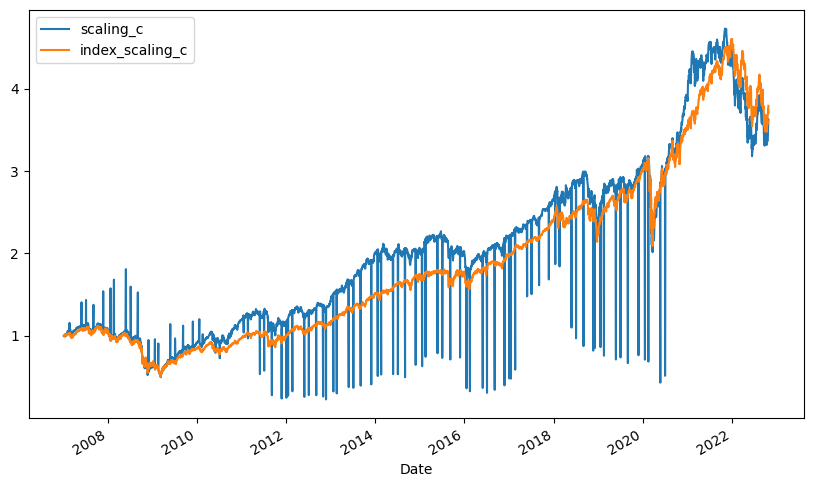

In [3]:
prices_c.groupby('Date').scaling_c.mean().plot(figsize=(10, 6), legend=True);
prices_c.groupby('Date').index_scaling_c.mean().plot(legend=True);

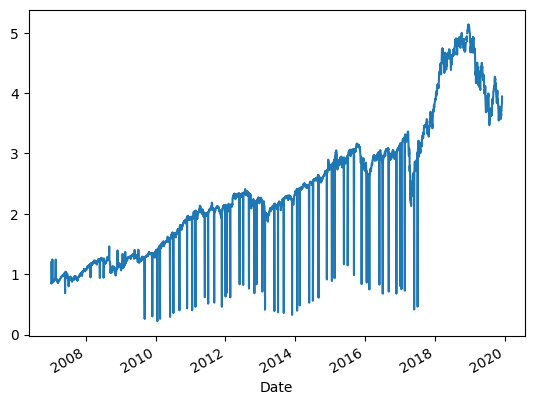

In [4]:
future = prices_c.groupby('Ticker').shift(-365*2)
future.groupby('Date').scaling_c.mean().plot();

In [5]:
prices_t = prices_c.join(future[['scaling_c', 'index_scaling_c']], how='inner', rsuffix='_future')
prices_t = prices_t.dropna(subset='scaling_c_future')
prices_t['alpha'] = (prices_t.scaling_c_future / prices_t.scaling_c) / (prices_t.index_scaling_c_future / prices_t.index_scaling_c)

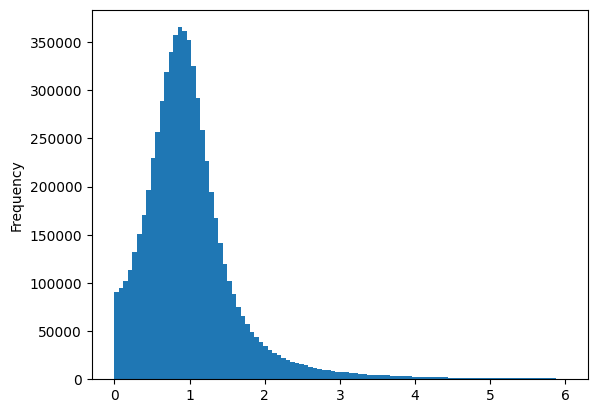

In [6]:
prices_t.alpha.plot.hist(range=[0, 6], bins=100);

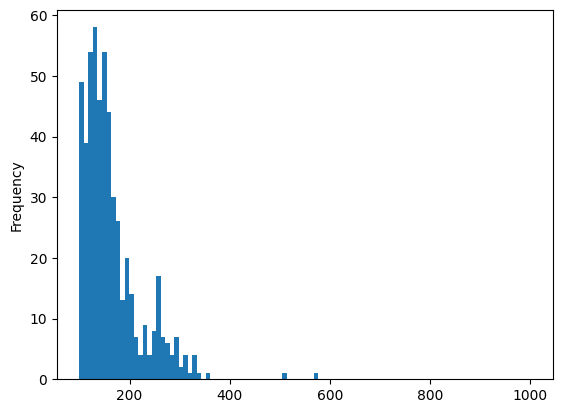

In [7]:
prices_t.alpha.plot.hist(range=[100, 1000], bins=100);

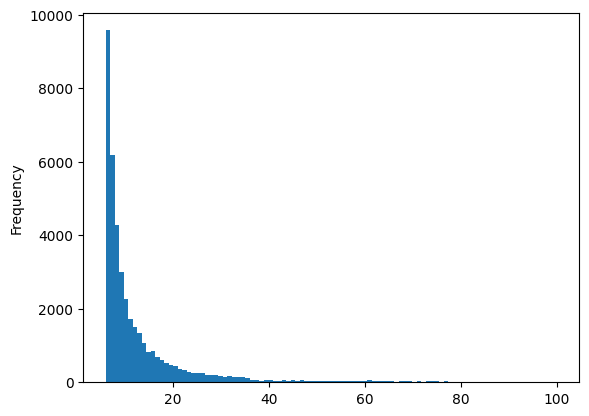

In [8]:
prices_t.alpha.plot.hist(range=[6, 100], bins=100);

In [9]:
prices_t['alpha_s'] = prices_t.alpha
prices_t.loc[prices_t.alpha_s < 1, 'alpha_s'] = -1/prices_t.alpha_s
prices_t.alpha_s = prices_t.alpha_s - prices_t.alpha_s.abs()/prices_t.alpha_s

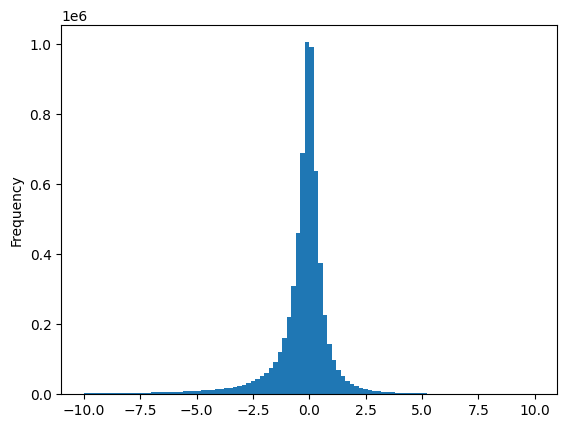

In [10]:
prices_t.alpha_s.plot.hist(range=[-10, 10], bins=100);

In [38]:
with fs.open('s3://snap-simfin/us-derived-shareprices-daily.zip') as f:
    dsp = pd.read_csv(f, compression='zip', sep=';')
    dsp['Date'] = pd.to_datetime(dsp.Date)
    dsp = dsp.set_index(['Ticker', 'Date'])

dsp = dsp.join(prices_t.alpha.dropna().to_frame(), how='inner')

dsp = dsp.drop(columns='SimFinId')

train = dsp.query("Date < '2019-01-01'")
test = dsp.query("Date >= '2019-01-01'")

In [39]:
from catboost import CatBoostRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
now = datetime.now()

m = CatBoostRegressor(
    random_seed=42,
    logging_level='Silent',
    objective='MAPE',
    max_depth=3,
    train_dir=f'train-{now.strftime("%Y-%m-%d-%H-%M-%S")}'
)

m.fit(train.drop(columns='alpha'), train.alpha)
m.score(test.drop(columns='alpha'), test.alpha)


-0.03516938375387468

In [40]:
pred = m.predict(test.drop(columns='alpha'))
test_p = test.copy()
test_p['pred'] = pred

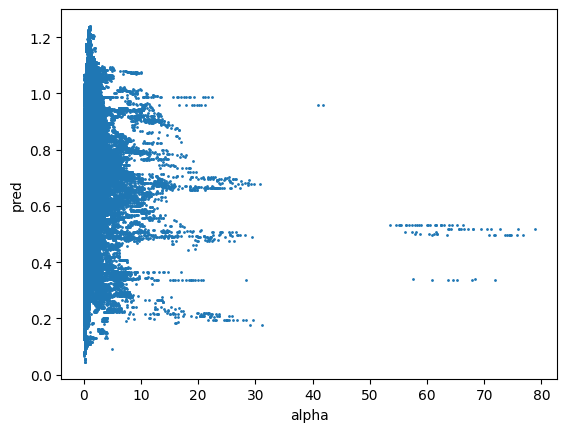

In [41]:
test_p.plot.scatter('alpha', 'pred', 1);

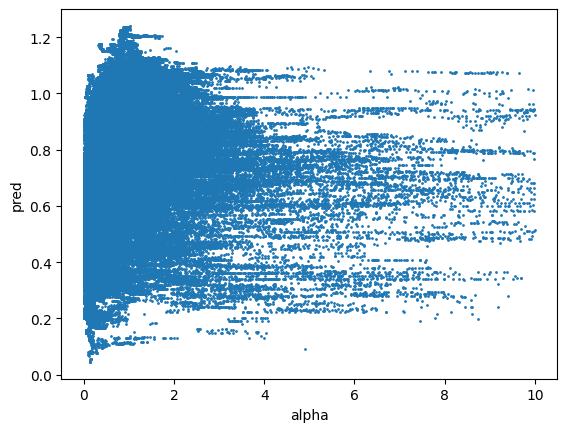

In [42]:
test_p[test_p.alpha < 10].plot.scatter('alpha', 'pred', 1);

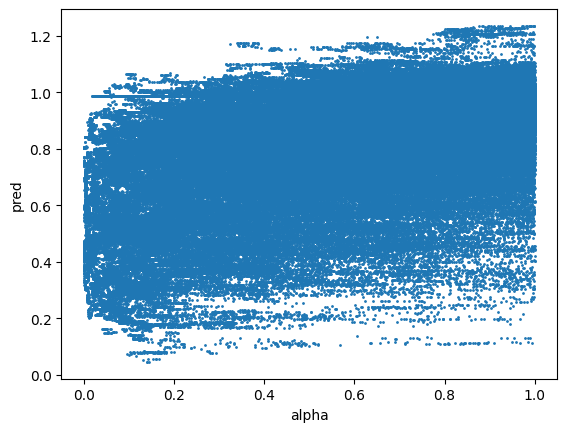

In [43]:
test_p[test_p.alpha < 1].plot.scatter('alpha', 'pred', 1);

In [44]:
m.score(test[test.alpha < 1].drop(columns='alpha'), test[test.alpha < 1].alpha)

-0.5529788417627206

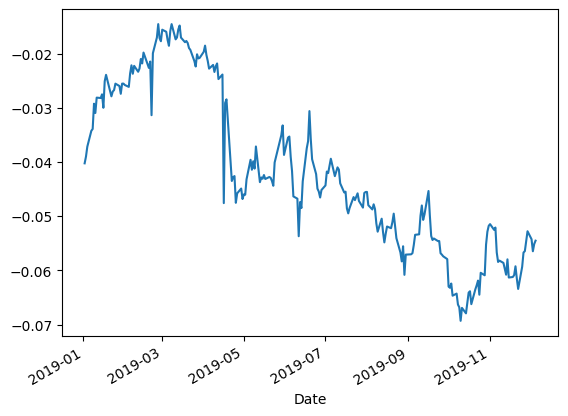

In [17]:
from sklearn.metrics import r2_score

def r_squared(x):
    return r2_score(x['alpha'], x['pred'])

test_p.groupby('Date').apply(r_squared).plot();

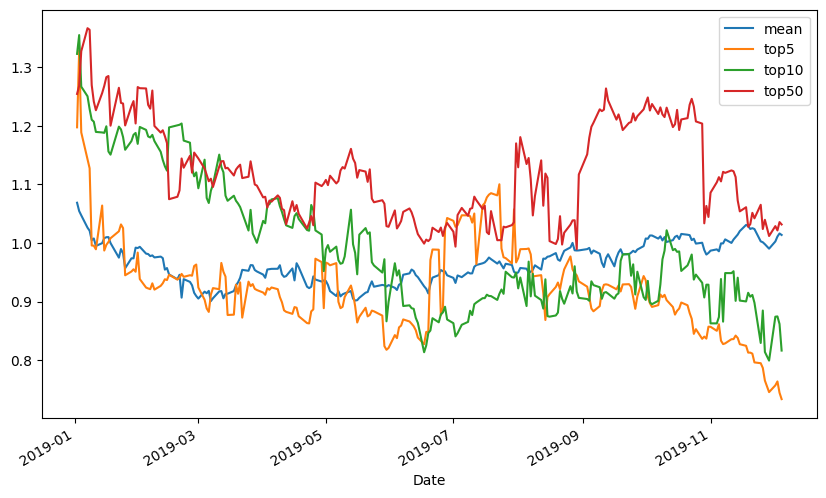

In [18]:
test_p.alpha.groupby('Date').mean().rename('mean').plot(figsize=(10, 6), legend=True)
top5 = test_p.sort_values('pred', ascending=False).groupby('Date').head(5).alpha.groupby('Date').mean().rename('top5')
top5.plot(legend=True)
top10 = test_p.sort_values('pred', ascending=False).groupby('Date').head(10).alpha.groupby('Date').mean().rename('top10')
top10.plot(legend=True)
top50 = test_p.sort_values('pred', ascending=False).groupby('Date').head(50).alpha.groupby('Date').mean().rename('top50')
top50.plot(legend=True);

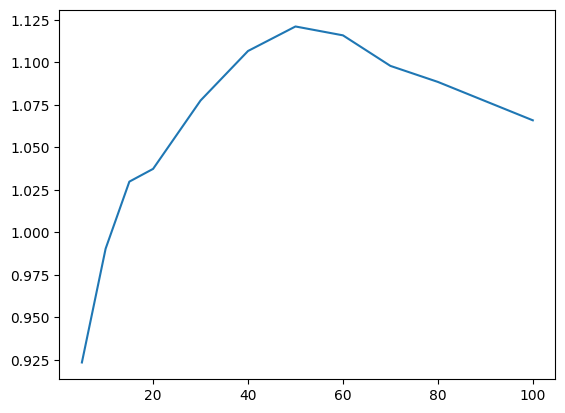

In [19]:
pd.Series({
    i: test_p.sort_values('pred', ascending=False).groupby('Date').head(i).alpha.mean()
    for i in [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 100]
}).plot();

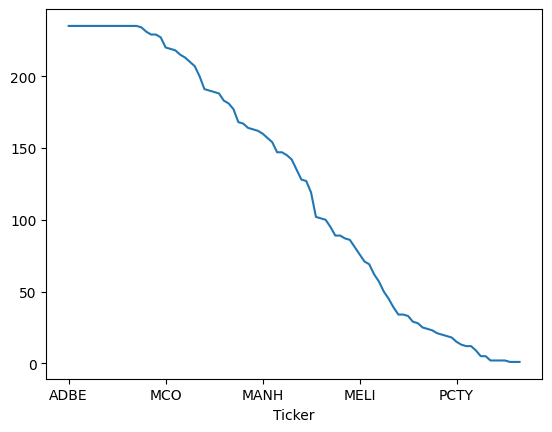

In [20]:
cnt = test_p.sort_values('pred', ascending=False).groupby('Date').head(50).groupby('Ticker').alpha.count().sort_values(ascending=False)
cnt.plot();

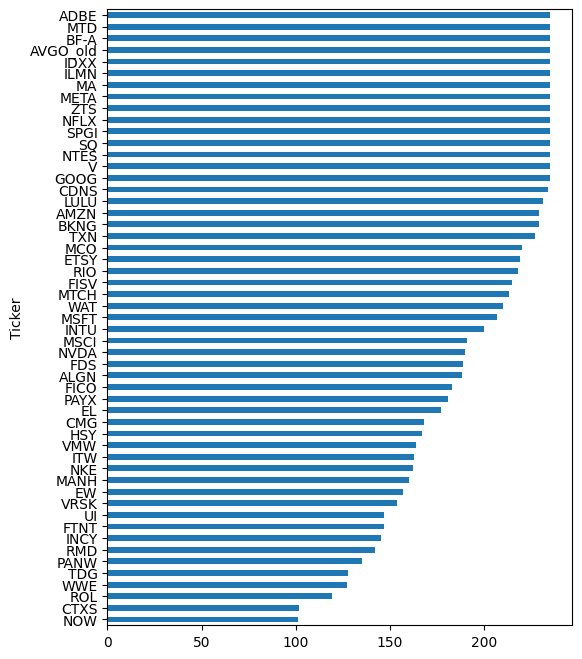

In [21]:
cnt[cnt > 100].sort_values().plot.barh(figsize=(6,8));

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


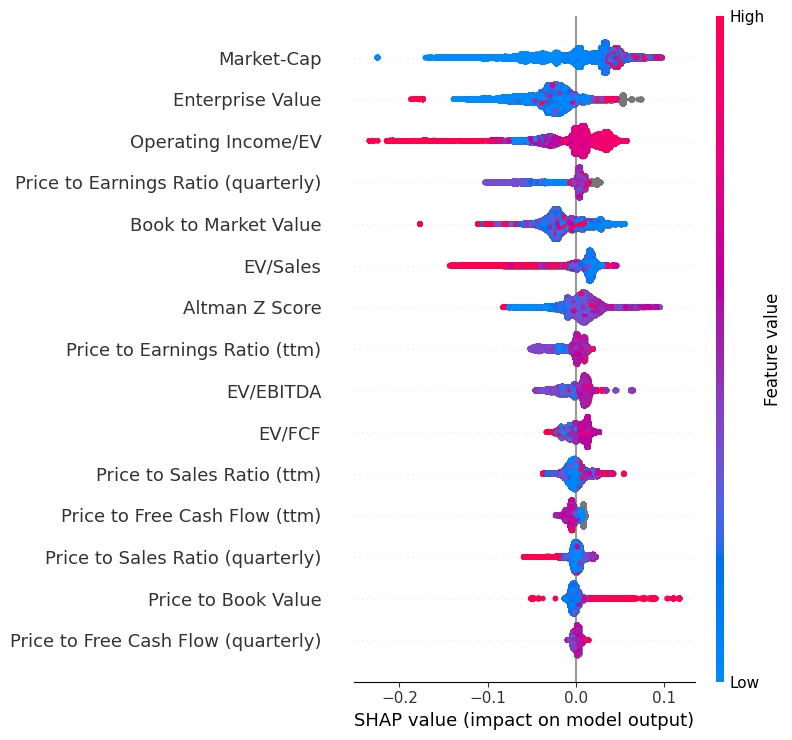

In [22]:
import shap

explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(test.drop(columns='alpha'))
shap.summary_plot(shap_values, test.drop(columns='alpha'))